In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os
import seaborn as sns

%matplotlib inline

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [20]:
train = pd.read_csv('data/equal_mix_train.csv')

part_codes = {'Ghost':0, 'Electron':11, 'Muon':13, 'Pion':211, 'Kaon':321, 'Proton':2212}
particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]

train.loc[~train['MCParticleType'].abs().isin(part_codes.values()), 'MCParticleType'] = 0
train_types = np.abs(train['MCParticleType'])
train_types_encoding = {part_codes[code]:index for index, code in enumerate(particles)}
labels = train_types.apply(lambda x: train_types_encoding[x])

mc_features = ['HasMC', 'MCParticleType', 'MCParticleP', 'MCParticlePt', 'MCVirtualMass', 
               'MCFromB', 'MCFromD', 'MCVertexType', 'MCVertexX', 'MCVertexY', 'MCVertexZ', 
               'piplus_OWNPV_X', 'piplus_OWNPV_Y', 'piplus_OWNPV_Z', 'piplus_OWNPV_XERR', 
               'piplus_OWNPV_YERR', 'piplus_OWNPV_ZERR', 'piplus_OWNPV_CHI2', 'piplus_OWNPV_NDOF', 
               'piplus_IP_OWNPV', 'piplus_IPCHI2_OWNPV', 'nCandidate', 'totCandidates', 'EventInSequence', 
               'TrackHistory', 'TrackType', 'RecoPIDcode']

constant_features = ['TrackMatchChi2', 'TrackCloneDist', 'RichUsedAero']

train.drop(mc_features + constant_features, axis=1, inplace=1)
#train.drop('Unnamed: 0.1', axis=1, inplace=1)

from sklearn.utils import shuffle

train, labels = shuffle(train, labels)

print train.shape

(300000, 77)


In [7]:
from itertools import combinations
from sklearn.metrics import roc_auc_score

parts = ['mu', 'p', 'e' , 'k']

def get_pairwiseDLL(X, group_prefix):
    pairwiseDLL = pd.DataFrame(index=X.index)
    
    X = X.copy()
    X[X == -999] = np.nan
    
    for part1, part2 in combinations(parts, 2):
        pairwiseDLL['{2}DLL{0}{1}'.format(part1, part2, group_prefix)] = \
                                                        X[group_prefix + 'DLL' + part1] - X[group_prefix + 'DLL' + part2]
        pairwiseDLL['{2}DLL{0}{1}'.format(part2, part1, group_prefix)] = \
                                                        X[group_prefix + 'DLL' + part2] - X[group_prefix + 'DLL' + part1]
        
    for part in parts:
        pairwiseDLL['{0}DLL{1}pi'.format(group_prefix, part)] = X[group_prefix + 'DLL' + part]
        pairwiseDLL['{0}DLLpi{1}'.format(group_prefix, part)] = -X[group_prefix + 'DLL' + part]
        
    pairwiseDLL.fillna(-999, inplace=1)
    
    return pairwiseDLL

def pairwise_AUC_DLL(X, group_prefix):
    aucs = np.ones(shape=(5, 5))
    parts_pi = parts + ['pi']
    part_map = dict(zip(['e', 'mu', 'pi', 'k', 'p'], range(5)))
    part_map_labels = dict(zip(parts_pi, [2, 5, 1, 4, 3]))
    for part1, part2 in combinations(parts + ['pi'], 2):
        ind1 = part_map[part1]
        ind2 = part_map[part2]
        label1 = part_map_labels[part1]
        label2 = part_map_labels[part2]

        mask = (labels == label1) | (labels == label2)
        lbls = labels[mask]
        lbls1 = lbls == label1
        feature1 = X.loc[mask, group_prefix + 'DLL{0}{1}'.format(part1, part2)]
        aucs[ind1, ind2] = roc_auc_score(lbls1, feature1)

        lbls2 = lbls == label2
        feature2 = X.loc[mask, group_prefix + 'DLL{0}{1}'.format(part2, part1)]
        aucs[ind2, ind1] = roc_auc_score(lbls2, feature2)
        
    from matplotlib import cm
    plt.figure(figsize=(10, 7))
    tick_labels = ['Electron', 'Muon', 'Pion', 'Kaon', 'Proton']
    sns.set()
    sns.heatmap(aucs, annot=1, xticklabels=tick_labels, yticklabels=tick_labels, fmt='.4f', cmap=cm.coolwarm, vmin=0.8, vmax=1.0)
    _ = plt.xticks(size=15)
    _ = plt.yticks(size=15)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


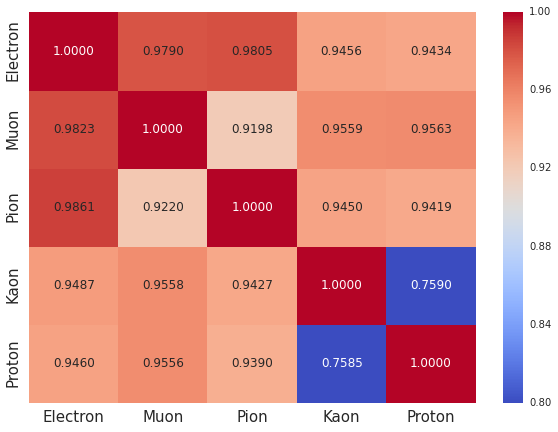

In [8]:
pairwise_AUC_DLL(get_pairwiseDLL(train, 'Comb'), 'Comb')

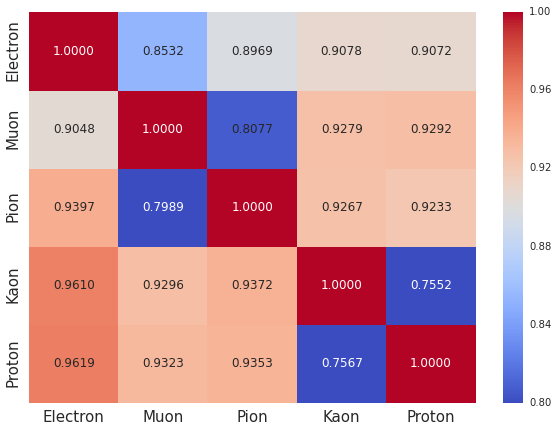

In [9]:
pairwise_AUC_DLL(get_pairwiseDLL(train, 'Rich'), 'Rich')

In [21]:
def get_probailities(X):
    X[X == -999] = 0
    probas = pd.DataFrame(index=X.index, data=np.exp(X.values), columns=map(lambda x: x + '_proba', X.columns))
    probas = probas.divide(probas.sum(axis=1), axis=0)
    #probas['not_all_proba'] = (1.-probas).prod(axis=1)
    
    return probas
    
    
def add_features(X):
    pairwiseCombDLLs = get_pairwiseDLL(X, 'Comb')
    pairwiseRichDLLs = get_pairwiseDLL(X, 'Rich')
    probabilitiesFromComb = get_probailities(X[filter(lambda x: 'CombDLL' in x, X.columns)])
    probabilitiesFromRich = get_probailities(X[filter(lambda x: 'RichDLL' in x, X.columns)])
    
    return pd.concat([X, pairwiseCombDLLs, pairwiseRichDLLs, probabilitiesFromComb, probabilitiesFromRich], axis=1)

train_added = add_features(train)
#eval_added = add_features(eval)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
from sklearn.preprocessing import Imputer

to_log = ['CaloNeutralPrs', 'CaloPrsE', 'CaloHcalE', 'CaloNeutralEcal', 'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs',
          'MuonNShared', 'CaloBremMatch', 'TrackPt', 'TrackP', 'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits',
          'NumMuonTracks', 'NumTTracks', 'TrackFitMatchChi2', 'TrackDOCA', 'CaloClusChi2', 'TrackFitVeloChi2',
          'CaloBremChi2', 'CaloChargedEcal', 'NumSPDHits', 'NumVeloTracks', 'TrackFitVeloNDoF', 'TrackFitTChi2', 'NumRich2Hits', ]

to_log_negative = {'CaloTrajectoryL', 'MuonMuLL', 'RichDLLbt', 'CombDLLp', 'RichDLLe', 'TrackLikelihood', 'CombDLLk', 
                   'RichDLLp', 'CaloEcalE', 'RichDLLmu', 'RichDLLk'}.union(set(filter(lambda x: 'DLL' in x, train_added.columns)))

# CaloChargedSpd - 1 or -999
# CombDLLpi, RichDLLpi  0 or -999

def log1p_negative(array):
    negative = array < 0
    array = np.log1p(np.abs(array))
    array[negative] *= -1
    return array

def preprocess_data(X):
    #X.loc[:, 'CaloChargedSpd'].replace(-999, 0, inplace=1)
    
    X[X == -999] = np.nan
    X_columns = X.columns

    imp = Imputer()
    X = imp.fit_transform(X)
    X = pd.DataFrame(data=X, columns=X_columns)

    for col in to_log:
        if col in X.columns:
            X[col] = np.log1p(X[col])
    for col in to_log_negative:
        if col in X.columns:
            X[col] = log1p_negative(X[col])
    return X
train = preprocess_data(train)
#eval = preprocess_data(eval)
train_added = preprocess_data(train_added)
#eval_added = preprocess_data(eval_added)

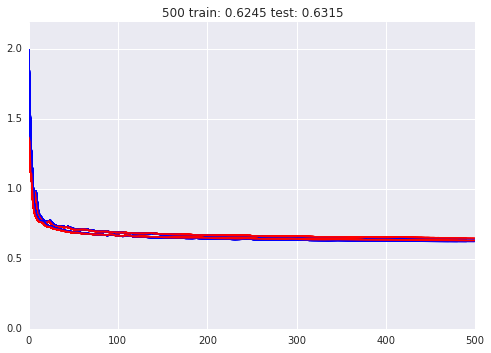

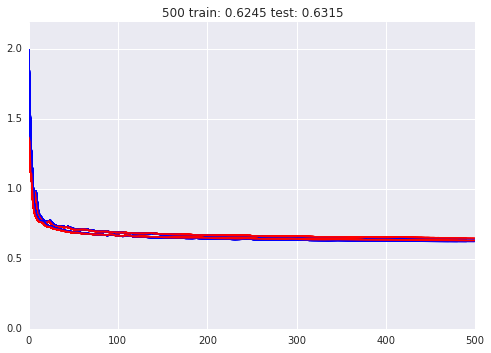

In [42]:
import theano.tensor as T
import lasagne
import theano
from IPython import display
from sklearn.cross_validation import train_test_split
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import softmax
from sklearn.preprocessing import scale

def test_nn(X, labels, num_epochs=500):

    input_layer = InputLayer(shape=[None, X.shape[1]])
    dense_layer1 = DenseLayer(input_layer, num_units=32)
    dense_layer2 = DenseLayer(dense_layer1, num_units=16)
    output_layer = DenseLayer(dense_layer2, num_units=6, nonlinearity=softmax)

    net_output = lasagne.layers.get_output(output_layer)
    true_output = T.ivector('true_output')
    loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))
    all_params = lasagne.layers.get_all_params(output_layer)
    updates = lasagne.updates.adagrad(loss, all_params, learning_rate=0.05)

    train_network = theano.function([input_layer.input_var, true_output], loss, updates=updates)
    get_output = theano.function([input_layer.input_var, ], net_output)
    calc_loss = theano.function([input_layer.input_var, true_output], loss)
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, labels, test_size=0.2, random_state=42)

    test_scores = []
    train_scores = []
    print 'Iter \t Train \t\t Test'
    for n in xrange(num_epochs):
        train_scores.append(train_network(scale(Xtrain), ytrain))
        test_scores.append(calc_loss(scale(Xtest), ytest))
        if n % 10 == 0 or n == num_epochs-1: 
            plt.plot(range(n+1), train_scores, label='train', c='b')
            plt.plot(range(n+1), test_scores, label='test', c='r')
            plt.ylim(0, min(2, max(train_scores)) + 0.2)
            plt.title('{0} train: {1:0.4f} test: {2:0.4f}'.format(n+1, float(train_scores[-1]), float(test_scores[-1])))
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
    return get_output(scale(Xtest)), ytest
            
preds, ytest = test_nn(train, labels)
preds_added, ytest_added = test_nn(train_added, labels)

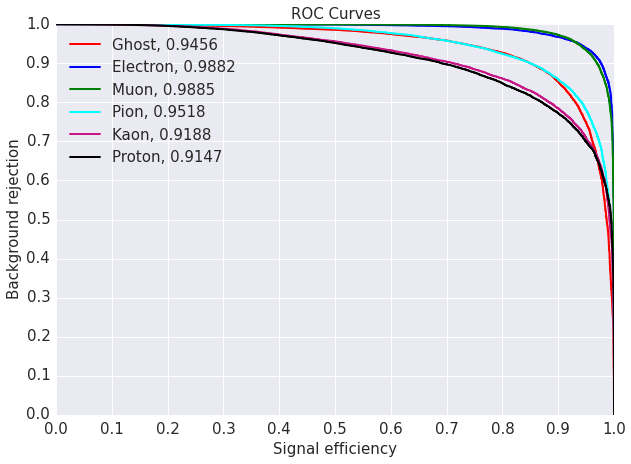

0.64902906724


In [43]:
from utils import get_roc_auc_matrix, get_roc_curves
from sklearn.metrics import log_loss

get_roc_curves(ytest, preds, particles)
print log_loss(ytest, preds)

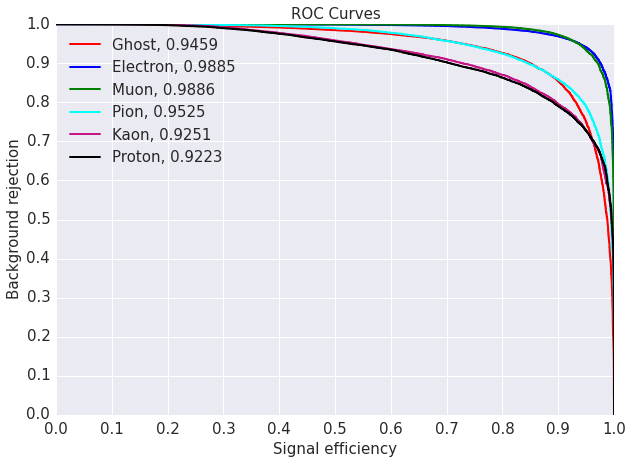

0.631513827828


In [44]:
get_roc_curves(ytest, preds_added, particles)
print log_loss(ytest, preds_added)

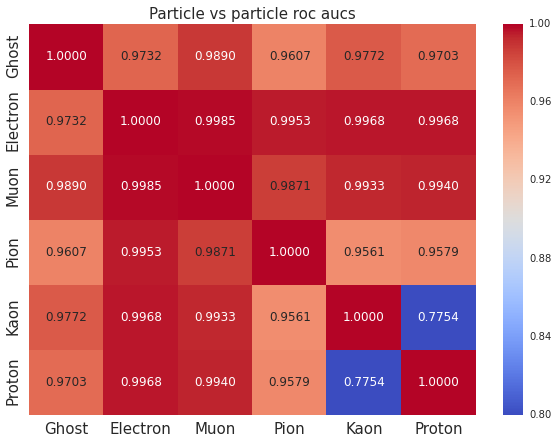

In [54]:
from utils import get_roc_auc_matrix

_ = get_roc_auc_matrix(ytest, preds, particles)

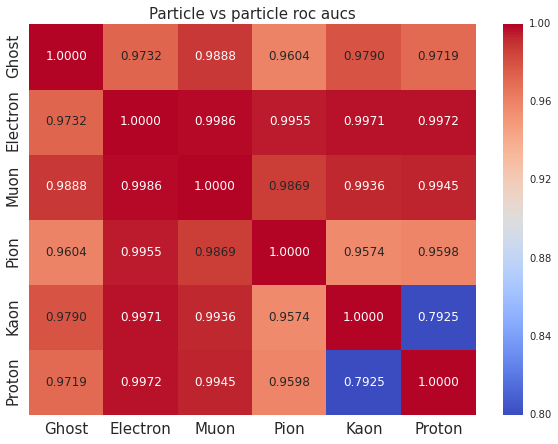

In [55]:
from utils import get_roc_auc_matrix

_ = get_roc_auc_matrix(ytest, preds_added, particles)